In [1]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES']='2'
%matplotlib inline

/home/lhw/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/lhw/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#数据读取
train_file_path = './data/training.csv'
test_file_path = './data/test.csv'

train_pd = pd.read_csv(train_file_path)
test_pd = pd.read_csv(test_file_path)
#去除含空值的行
train_pd.dropna(axis=0, how='any', inplace=True)
print(train_pd.shape)

(2140, 31)


In [3]:
from joblib import Parallel, delayed
def format_img(x):
    return np.asarray([int(e) for e in x.split(' ')], dtype=np.uint8).reshape(96, 96)
#并行处理，将图片抽取出来
with Parallel(n_jobs=10, verbose=1, prefer='threads') as ex:
    train_img = ex(delayed(format_img)(e) for e in train_pd.Image)
with Parallel(n_jobs=10, verbose=1, prefer='threads') as ex:
    test_img = ex(delayed(format_img)(e) for e in test_pd.Image)
train_img = np.stack(train_img)[..., None]
test_img = np.stack(test_img)[..., None]
print(train_img.shape, test_img.shape)

[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    7.9s
[Parallel(n_jobs=10)]: Done 1780 tasks      | elapsed:   11.4s
[Parallel(n_jobs=10)]: Done 2140 out of 2140 | elapsed:   13.7s finished
[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.2s
[Parallel(n_jobs=10)]: Done 180 tasks      | elapsed:    1.3s
[Parallel(n_jobs=10)]: Done 430 tasks      | elapsed:    2.8s
[Parallel(n_jobs=10)]: Done 780 tasks      | elapsed:    5.1s
[Parallel(n_jobs=10)]: Done 1230 tasks      | elapsed:    8.0s


(2140, 96, 96, 1) (1783, 96, 96, 1)


[Parallel(n_jobs=10)]: Done 1783 out of 1783 | elapsed:   11.7s finished


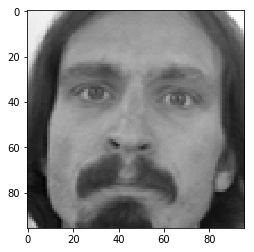

In [4]:
plt.imshow(train_img[0, :, :, 0], cmap='gray')
plt.show()

In [5]:
#获取关键点坐标
train_y = train_pd.iloc[:, :-1].values
print(train_y.shape)
print(train_y[1, :])

(2140, 30)
[64.33293617 34.9700766  29.9492766  33.44871489 58.85617021 35.27434894
 70.7227234  36.18716596 36.0347234  34.36153191 24.47251064 33.14444255
 53.98740426 28.27594894 78.63421277 30.4059234  42.72885106 26.14604255
 16.8653617  27.05885957 48.20629787 55.66093617 56.42144681 76.352
 35.12238298 76.04765957 46.68459574 70.26655319 45.46791489 85.48017021]


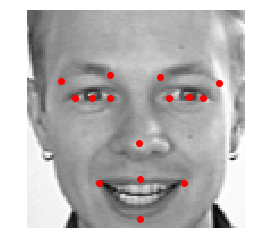

In [6]:
#将关键点和图像相融合
def show(x, y=None):
    plt.imshow(x[..., 0], 'gray')
    if y is not None:
        #np.vstack(np.split(y, 15))先切分成15组，再按组相连 
        #[1, 2, 3, 4,, 5, 6]=>[1, 2,],[3, 4], [5, 6]=>[[1,2], [3, 4], [5, 6]]
        points = np.vstack(np.split(y, 15)).T
        plt.plot(points[0], points[1], 'o', color = 'red')
    plt.axis('off')
sample_idx = np.random.choice(len(train_img))
show(train_img[sample_idx], train_y[sample_idx])

In [7]:
#数据预处理
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train_img, train_y, test_size=0.2, random_state=42, shuffle=True)#random_state：是随机数的种子
print(x_train.shape, x_val.shape)
print(y_val[0].shape)

(1712, 96, 96, 1) (428, 96, 96, 1)
(30,)


In [12]:
#定义模型
def model(input, is_training):
    with tf.variable_scope('layer1'):
        conv1 = tf.layers.conv2d(input, 32, 3, strides=1, padding='VALID')
        relu1 = tf.nn.relu(conv1)
        norm1 = tf.layers.batch_normalization(relu1, center=True, scale=True, training=True)
        pool1 = tf.layers.max_pooling2d(norm1, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer2'):
        conv2 = tf.layers.conv2d(pool1, 64, 2, strides=1, padding='VALID')
        relu2= tf.nn.relu(conv2)
        norm2 = tf.layers.batch_normalization(relu2, center=True, scale=True, training=True)
        pool2 = tf.layers.max_pooling2d(norm2, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer3'):
        conv3 = tf.layers.conv2d(pool2, 128, 2, strides=1, padding='VALID')
        relu3 = tf.nn.relu(conv3)
        norm3 = tf.layers.batch_normalization(relu3, center=True, scale=True, training=True)
        pool3 = tf.layers.max_pooling2d(norm3, pool_size=[2, 2], strides=2, padding='SAME')
    with tf.variable_scope('layer4'):
        flatten = tf.reshape(pool3, [-1, 11*11*128])
        layer4 = tf.layers.dense(flatten, 1024)
        relu4 = tf.nn.relu(layer4)
        if is_training == True:
            relu4 = tf.layers.dropout(relu4, 0.5)
    with tf.variable_scope('layer5'):
        layer5 = tf.layers.dense(relu4, 500)
        relu5 = tf.nn.relu(layer5)
        output = tf.layers.dense(relu5, 30)
    return output

In [15]:
#训练

ckpt_path = './model/model.ckpt'
tf.reset_default_graph()
x_data = tf.placeholder(tf.float32, [None, 96, 96, 1])
y_data = tf.placeholder(tf.float32, [None, 30])
is_training = tf.placeholder(tf.bool)

out = model(x_data, is_training)
#损失函数 rsme
rmse = tf.sqrt(tf.reduce_mean(tf.square(y_data - out)))
train_step = tf.train.AdadeltaOptimizer(0.03).minimize(rmse)
saver = tf.train.Saver()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    epoch = 500
    batch_size = 100
    num_batch = len(x_train) // batch_size
    print(num_batch)
    for n in range(epoch):
        for i in range(num_batch):
            x_batch = x_train[i*batch_size : (i+1)*batch_size]
            y_batch = y_train[i*batch_size : (i+1)*batch_size]
            _, loss_step = sess.run([train_step, rmse], \
                             feed_dict={x_data:x_batch, y_data:y_batch, is_training:True})
        validation_loss = rmse.eval(feed_dict={x_data:x_val, y_data:y_val, is_training:False})
        print("epoch %d validataion loss is %f" % (n, validation_loss))
    saver.save(sess, ckpt_path)

17
epoch 0 validataion loss is 44.661877
epoch 1 validataion loss is 24.139799
epoch 2 validataion loss is 10.923390
epoch 3 validataion loss is 7.380291
epoch 4 validataion loss is 5.986128
epoch 5 validataion loss is 5.730978
epoch 6 validataion loss is 5.590342
epoch 7 validataion loss is 5.177580
epoch 8 validataion loss is 5.359661
epoch 9 validataion loss is 5.107779
epoch 10 validataion loss is 5.204309
epoch 11 validataion loss is 5.022206
epoch 12 validataion loss is 5.079712
epoch 13 validataion loss is 4.941722
epoch 14 validataion loss is 4.973669
epoch 15 validataion loss is 4.869764
epoch 16 validataion loss is 4.883642
epoch 17 validataion loss is 4.795941
epoch 18 validataion loss is 4.803029
epoch 19 validataion loss is 4.731261
epoch 20 validataion loss is 4.729906
epoch 21 validataion loss is 4.667275
epoch 22 validataion loss is 4.661673
epoch 23 validataion loss is 4.609894
epoch 24 validataion loss is 4.601640
epoch 25 validataion loss is 4.557441
epoch 26 validat

epoch 213 validataion loss is 3.142913
epoch 214 validataion loss is 3.360983
epoch 215 validataion loss is 3.133726
epoch 216 validataion loss is 3.355142
epoch 217 validataion loss is 3.128960
epoch 218 validataion loss is 3.351597
epoch 219 validataion loss is 3.124804
epoch 220 validataion loss is 3.346351
epoch 221 validataion loss is 3.121845
epoch 222 validataion loss is 3.343568
epoch 223 validataion loss is 3.119102
epoch 224 validataion loss is 3.341667
epoch 225 validataion loss is 3.114782
epoch 226 validataion loss is 3.340333
epoch 227 validataion loss is 3.106747
epoch 228 validataion loss is 3.333587
epoch 229 validataion loss is 3.103687
epoch 230 validataion loss is 3.328312
epoch 231 validataion loss is 3.103871
epoch 232 validataion loss is 3.328341
epoch 233 validataion loss is 3.095158
epoch 234 validataion loss is 3.322766
epoch 235 validataion loss is 3.094612
epoch 236 validataion loss is 3.321591
epoch 237 validataion loss is 3.092740
epoch 238 validataion los

epoch 424 validataion loss is 3.122947
epoch 425 validataion loss is 2.902982
epoch 426 validataion loss is 3.123224
epoch 427 validataion loss is 2.904237
epoch 428 validataion loss is 3.119594
epoch 429 validataion loss is 2.901949
epoch 430 validataion loss is 3.123323
epoch 431 validataion loss is 2.898242
epoch 432 validataion loss is 3.119714
epoch 433 validataion loss is 2.902443
epoch 434 validataion loss is 3.115251
epoch 435 validataion loss is 2.899774
epoch 436 validataion loss is 3.114206
epoch 437 validataion loss is 2.898674
epoch 438 validataion loss is 3.114938
epoch 439 validataion loss is 2.895247
epoch 440 validataion loss is 3.107895
epoch 441 validataion loss is 2.898069
epoch 442 validataion loss is 3.110536
epoch 443 validataion loss is 2.899330
epoch 444 validataion loss is 3.108909
epoch 445 validataion loss is 2.894550
epoch 446 validataion loss is 3.103805
epoch 447 validataion loss is 2.892999
epoch 448 validataion loss is 3.104300
epoch 449 validataion los

In [22]:
def show_pred(x, y_real, y_pred):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    for ax in axes:
        ax.imshow(x[0, ..., 0], 'gray')
        ax.axis('off')
    points_real = np.vstack(np.split(y_real[0], 15)).T
    points_pred = np.vstack(np.split(y_pred[0], 15)).T
    axes[0].plot(points_pred[0], points_pred[1], 'o', color='red')
    axes[0].set_title('Predictions', size=16)
    axes[1].plot(points_real[0], points_real[1], 'o', color='green')
    axes[1].plot(points_pred[0], points_pred[1], 'o', color='red', alpha=0.5)
    axes[1].set_title('Real', size=16)

INFO:tensorflow:Restoring parameters from ./model/model.ckpt


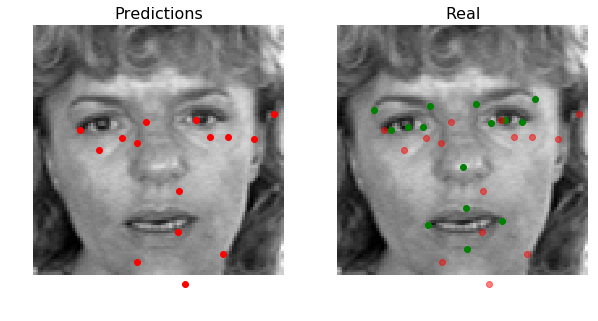

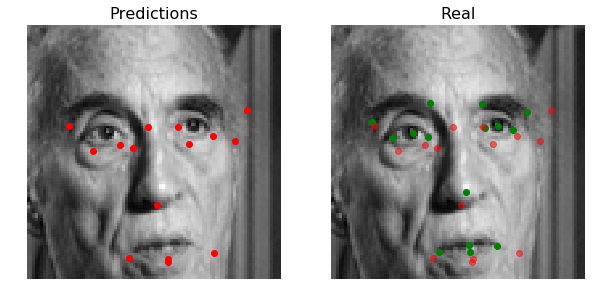

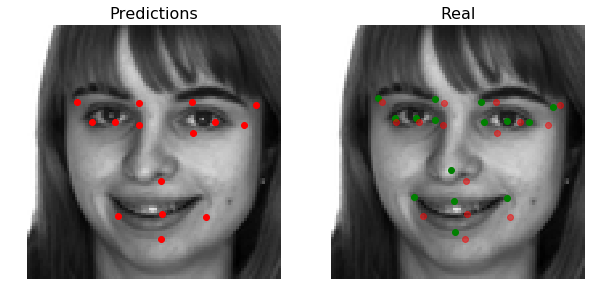

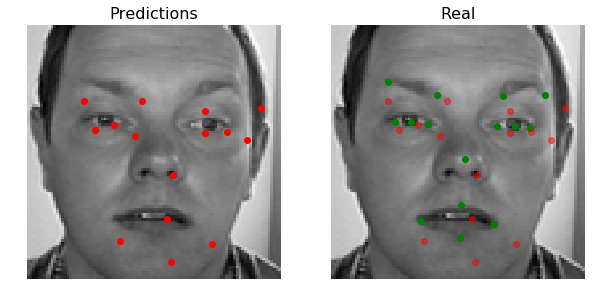

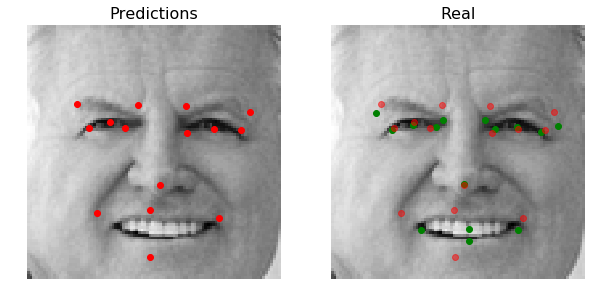

In [26]:
#测试
ckpt_path = './model/model.ckpt'
tf.reset_default_graph()
x_val_data = tf.placeholder(tf.float32, [None, 96, 96, 1])
is_training = tf.placeholder(tf.bool)
predict = model(x_val_data, is_training)
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, ckpt_path)
    for i in range(5):
        idx = np.random.choice(len(x_val))
        sample_x = x_val[idx, None]#增加一维(1, 96, 96, 1) 而x_val[0]=>( 96, 96, 1)
        sample_y = y_val[idx, None]
        sess.run(predict, feed_dict={x_val_data:sample_x, is_training:False})
        pred = predict.eval(feed_dict={x_val_data:sample_x, is_training:False})
        show_pred(sample_x, sample_y, pred)